# Fine-Tuning avec Transfer Learning
Déblocage des dernières couches du modèle pour un entraînement plus précis.

In [9]:
# --- IMPORTS ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
from scipy.io import loadmat

# --- Chargement des donnees ---
train_list_path = '../data/raw/train_list.mat'
val_list_path = '../data/raw/test_list.mat'
processed_images_dir = "../data/processed/Images"

def load_file_list(mat_path):
    mat = loadmat(mat_path)
    return [item[0][0] for item in mat["file_list"]]

def get_label_from_path(path):
    return path.split('/')[0]

train_list = load_file_list(train_list_path)
val_list = load_file_list(val_list_path)

train_labels = [get_label_from_path(p) for p in train_list]
val_labels = [get_label_from_path(p) for p in val_list]

train_paths = [os.path.join(processed_images_dir, path) for path in train_list]
val_paths = [os.path.join(processed_images_dir, path) for path in val_list]

train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})

# --- Preparer les generateurs ---
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# --- Chemin du modele ---
final_model_path = '../models/final_transfer_model.h5'

# --- Modele : charger si existant, sinon entrainer ---
if os.path.exists(final_model_path):
    print(f"📦 Chargement du modèle existant depuis '{final_model_path}'...")
    model = load_model(final_model_path)
else:
    print("🚀 Aucun modèle existant. Construction et entraînement d'un nouveau modèle...")

    # --- Construction du modele de base ---
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(120, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # --- Callbacks ---
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint('../models/best_transfer_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
    ]

    # --- Entrainement tete ---
    history_base = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,
        callbacks=callbacks
    )

    # --- Fine-tuning ---
    print("🔓 Déblocage des dernières couches du VGG16...")
    base_model.trainable = True

    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history_fine = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,
        callbacks=callbacks
    )

    # --- Sauvegarde du modele final ---
    model.save(final_model_path)
    print(f"✅ Modèle final sauvegardé sous '{final_model_path}'.")

# train_gen.class_indices donne {class_name: index}
with open('../models/class_indices.json', 'w') as f:
    json.dump(train_gen.class_indices, f)

print("✅ Dictionnaire 'class_indices' sauvegardé dans '../models/class_indices.json'.")

print("🏁 Script terminé.")


Found 12000 validated image filenames belonging to 120 classes.
Found 8580 validated image filenames belonging to 120 classes.
📦 Chargement du modèle existant depuis '../models/final_transfer_model.h5'...
✅ Dictionnaire 'class_indices' sauvegardé dans '../models/class_indices.json'.
🏁 Script terminé.


## Comparaison des performances
Comparer les performances avant et après le fine-tuning.

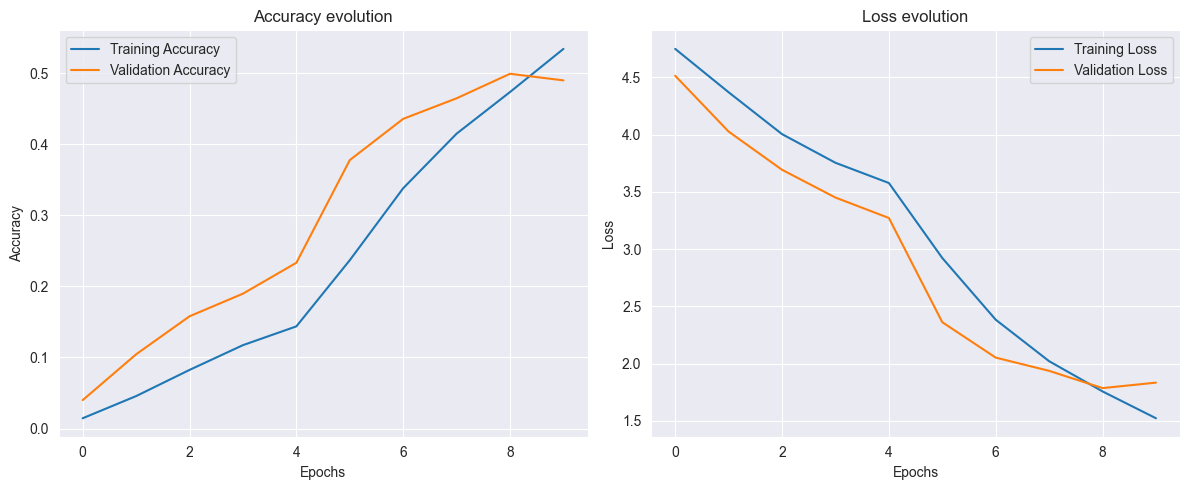

In [6]:
# --- Affichage des courbes ---
plt.figure(figsize=(12, 5))

# Courbe accuracy
plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_base.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Courbe loss
plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'] + history_fine.history['loss'], label='Training Loss')
plt.plot(history_base.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.title('Loss evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()